# 각 아파트 가격 정보 EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import gc
from sklearn.preprocessing import MinMaxScaler

# 맥에서 글씨 깨짐 방지
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df = pd.read_csv('../data/preprocessed/27_school_district.csv')

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_43349/3515905086.py:1: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/preprocessed/27_school_district.csv')


In [3]:
apart_name_list = df['아파트명'].unique()

In [4]:
len(apart_name_list)

6550

# 이상치 탐색
- 갑자기 뚝 떨어지는 구간
- 갑자기 확 상승하는 구간

##### 1

In [5]:
tmp = df[df['아파트명']==apart_name_list[0]][['아파트명', '계약년월', 'target']]
tmp

,아파트명,계약년월,target
0,개포6차우성,201712,124000.0
1,개포6차우성,201712,123500.0
2,개포6차우성,201712,91500.0
3,개포6차우성,201801,130000.0
4,개포6차우성,201801,117000.0
...,...,...,...
1004784,개포6차우성,200804,89000.0
1004785,개포6차우성,200805,81000.0
1075994,개포6차우성,200703,93000.0
1075995,개포6차우성,200703,69300.0


In [6]:
tmp_target_df = pd.DataFrame(tmp.groupby('계약년월')['target'].mean())
tmp_target_df.reset_index(inplace=True)
tmp_target_df

,계약년월,target
0,200703,81150.0
1,200804,89000.0
2,200805,81000.0
3,200810,73000.0
4,200902,74000.0
...,...,...
65,202109,220000.0
66,202112,215000.0
67,202204,220000.0
68,202205,216000.0


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


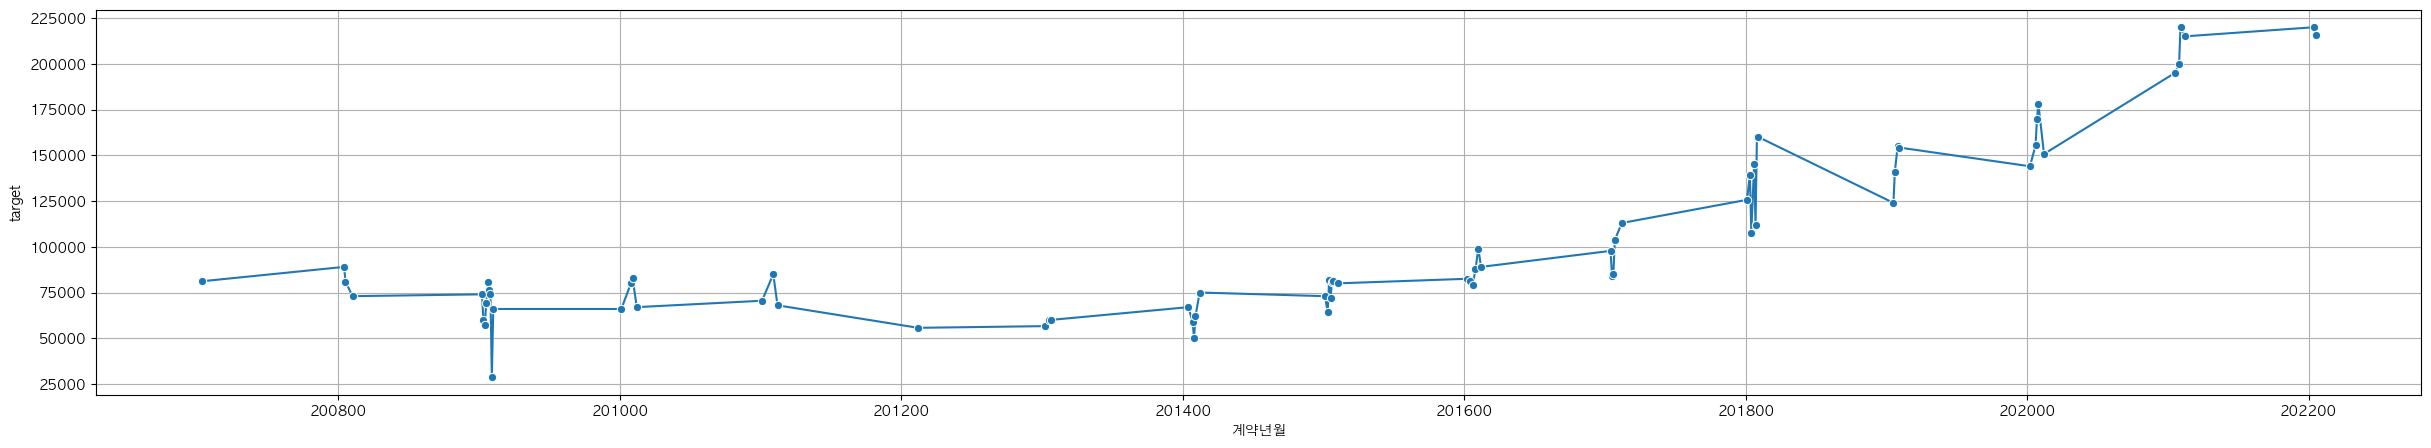

In [7]:
plt.figure(figsize=(30, 5))
sns.lineplot(x='계약년월', y='target', data=tmp_target_df, marker='o')
plt.grid(True)
plt.show()

In [8]:
tmp[(tmp['계약년월']>=200800) & (tmp['계약년월']<=201000)]

,아파트명,계약년월,target
133981,개포6차우성,200810,73000.0
133982,개포6차우성,200902,74000.0
133983,개포6차우성,200903,59750.0
133984,개포6차우성,200904,57500.0
133985,개포6차우성,200905,58000.0
133986,개포6차우성,200905,80500.0
133987,개포6차우성,200906,80500.0
133988,개포6차우성,200907,67700.0
133989,개포6차우성,200907,85000.0
133990,개포6차우성,200908,74000.0


#### 2

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


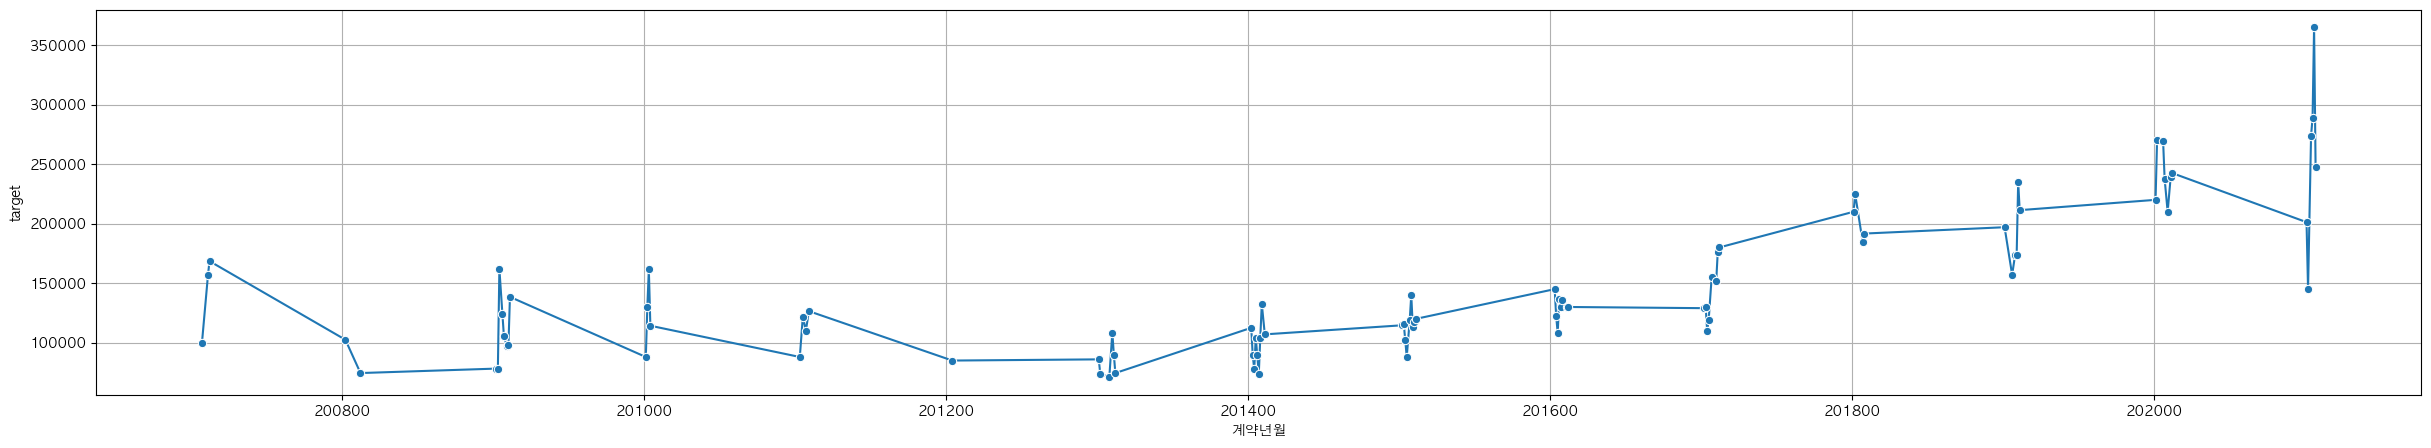

In [9]:
tmp = df[df['아파트명']==apart_name_list[1]][['아파트명', '계약년월', 'target']]

tmp_target_df = pd.DataFrame(tmp.groupby('계약년월')['target'].mean())
tmp_target_df.reset_index(inplace=True)

plt.figure(figsize=(30, 5))
sns.lineplot(x='계약년월', y='target', data=tmp_target_df, marker='o')
plt.grid(True)
plt.show()

In [10]:
tmp.iloc[0, 2]=10
tmp

,아파트명,계약년월,target
12,개포우성3차,201710,10.0
13,개포우성3차,201711,182000.0
14,개포우성3차,201711,170000.0
15,개포우성3차,201712,185000.0
16,개포우성3차,201712,175000.0
...,...,...,...
1004788,개포우성3차,200802,102500.0
1075996,개포우성3차,200707,99900.0
1118824,개포우성3차,202307,NaN
1118825,개포우성3차,202308,NaN


# 이상치 처리
- 양 옆의 2년 총 4년치의 평균보다 2배이상 크거나 2배이하 작은 경우 이상치로 판단
- 양 사이드 4년의 평균 값으로 값을 대체한다.

1. '계약년월'을 기준으로 그룹화
2. 이상치가 존재하는 위치를 찾는다.
3. 해당 '계약년월'의 값을 모두 평균으로 처리

In [11]:
# 1. '아파트명'을 기준으로 데이터를 분할한다.
train_df = df[df['is_test'] == 0]
apart_df_list = []

for apart in apart_name_list:
    apart_df_list.append(train_df[train_df['아파트명'] == apart])

In [13]:
# 2. 이상치 처리

def find_outlier(apart_df):
    tmp = apart_df.sort_values(['계약년월', '계약일'])
    tmp.reset_index(inplace=True)
    l = tmp.shape[0]

    for i in range(2, l-2):
        current = tmp.iloc[i]['target']
        mn = (tmp.iloc[i-2:i+3]['target'].sum() - current)/4

        if (current <= (mn/2)) or (current >= (mn*2)):
            tmp.iloc[i, 52] = mn
    
    return tmp

In [14]:
test = apart_df_list[0].sort_values(['계약년월', '계약일'])
test.reset_index(inplace=True)
test

,level_0,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,...,아파트 카테고리,지하철 카테고리,구 카테고리,건설사 카테고리,가장 가까운 다리와의 거리,가장 가까운 다리 index,가장 가까운 다리,인근 한강다리 개수,인근 다리 개수 1개이상 3개 이하,학군
0,1075994,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,200703,9,2,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
1,1075995,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,200703,9,4,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
2,1004784,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,200804,17,4,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
3,1004785,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,200805,10,5,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
4,133981,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,200810,4,1,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,236526,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202109,2,2,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
97,222654,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202112,4,3,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
98,222655,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202204,12,4,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
99,222656,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202204,21,2,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0


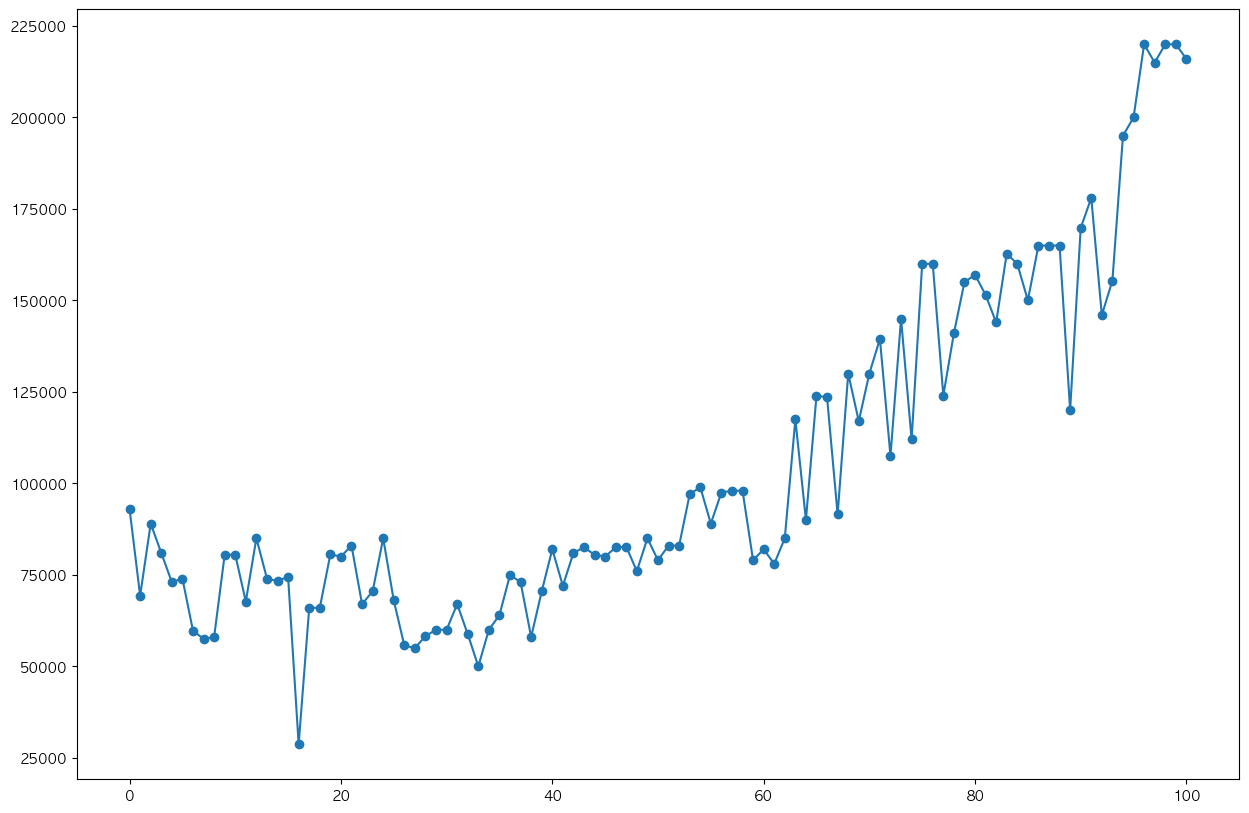

In [15]:
plt.figure(figsize=(15, 10))
test['target'].plot(marker='o')
plt.show()

In [16]:
test2 = find_outlier(apart_df_list[0])
test2

,level_0,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,...,아파트 카테고리,지하철 카테고리,구 카테고리,건설사 카테고리,가장 가까운 다리와의 거리,가장 가까운 다리 index,가장 가까운 다리,인근 한강다리 개수,인근 다리 개수 1개이상 3개 이하,학군
0,1075994,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,200703,9,2,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
1,1075995,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,200703,9,4,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
2,1004784,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,200804,17,4,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
3,1004785,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,200805,10,5,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
4,133981,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,200810,4,1,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,236526,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202109,2,2,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
97,222654,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202112,4,3,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
98,222655,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202204,12,4,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
99,222656,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202204,21,2,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0


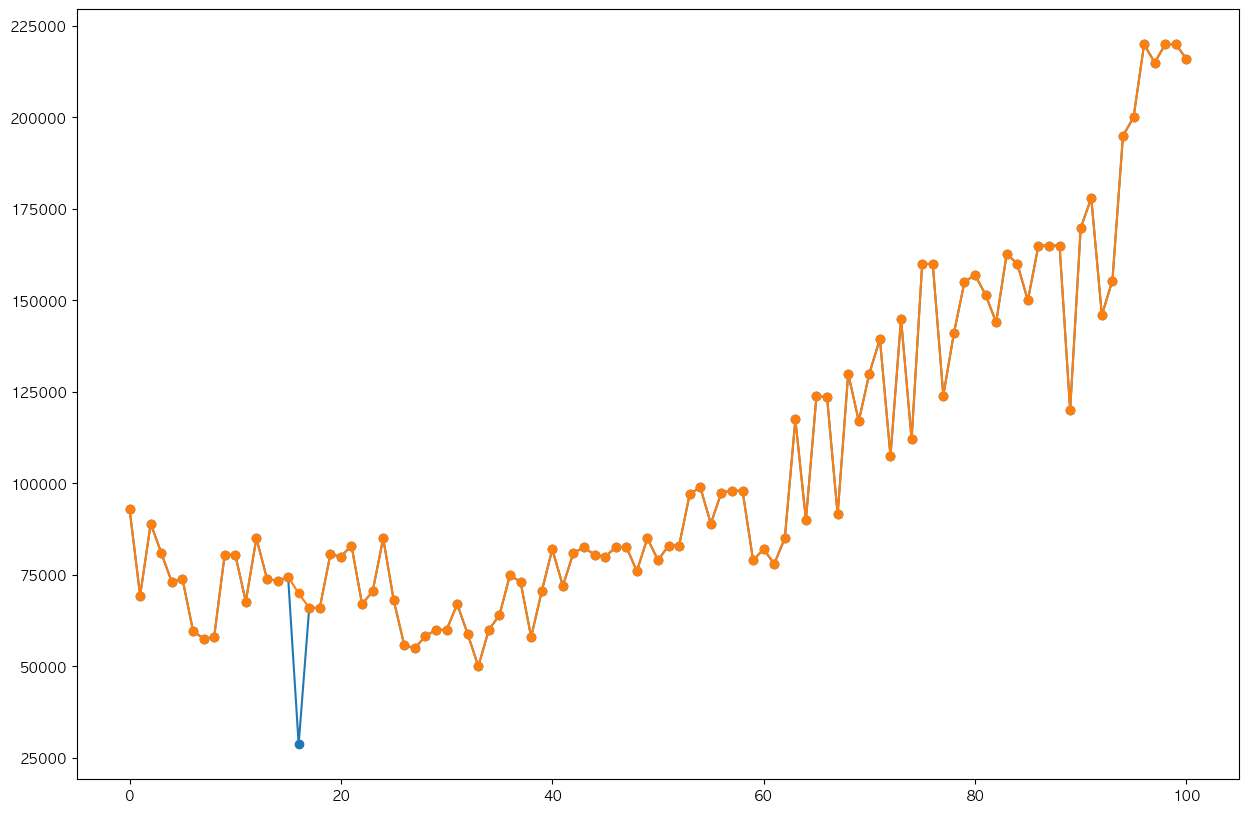

In [17]:
plt.figure(figsize=(15, 10))
test['target'].plot(marker='o')
test2['target'].plot(marker = 'o')
plt.show()

In [18]:
# 모든 데이터에 사용

result = []
l = len(apart_df_list)

for i in range(l):
    if i % 50 == 0:
        print(i)
    result.append(find_outlier(apart_df_list[i]))

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500


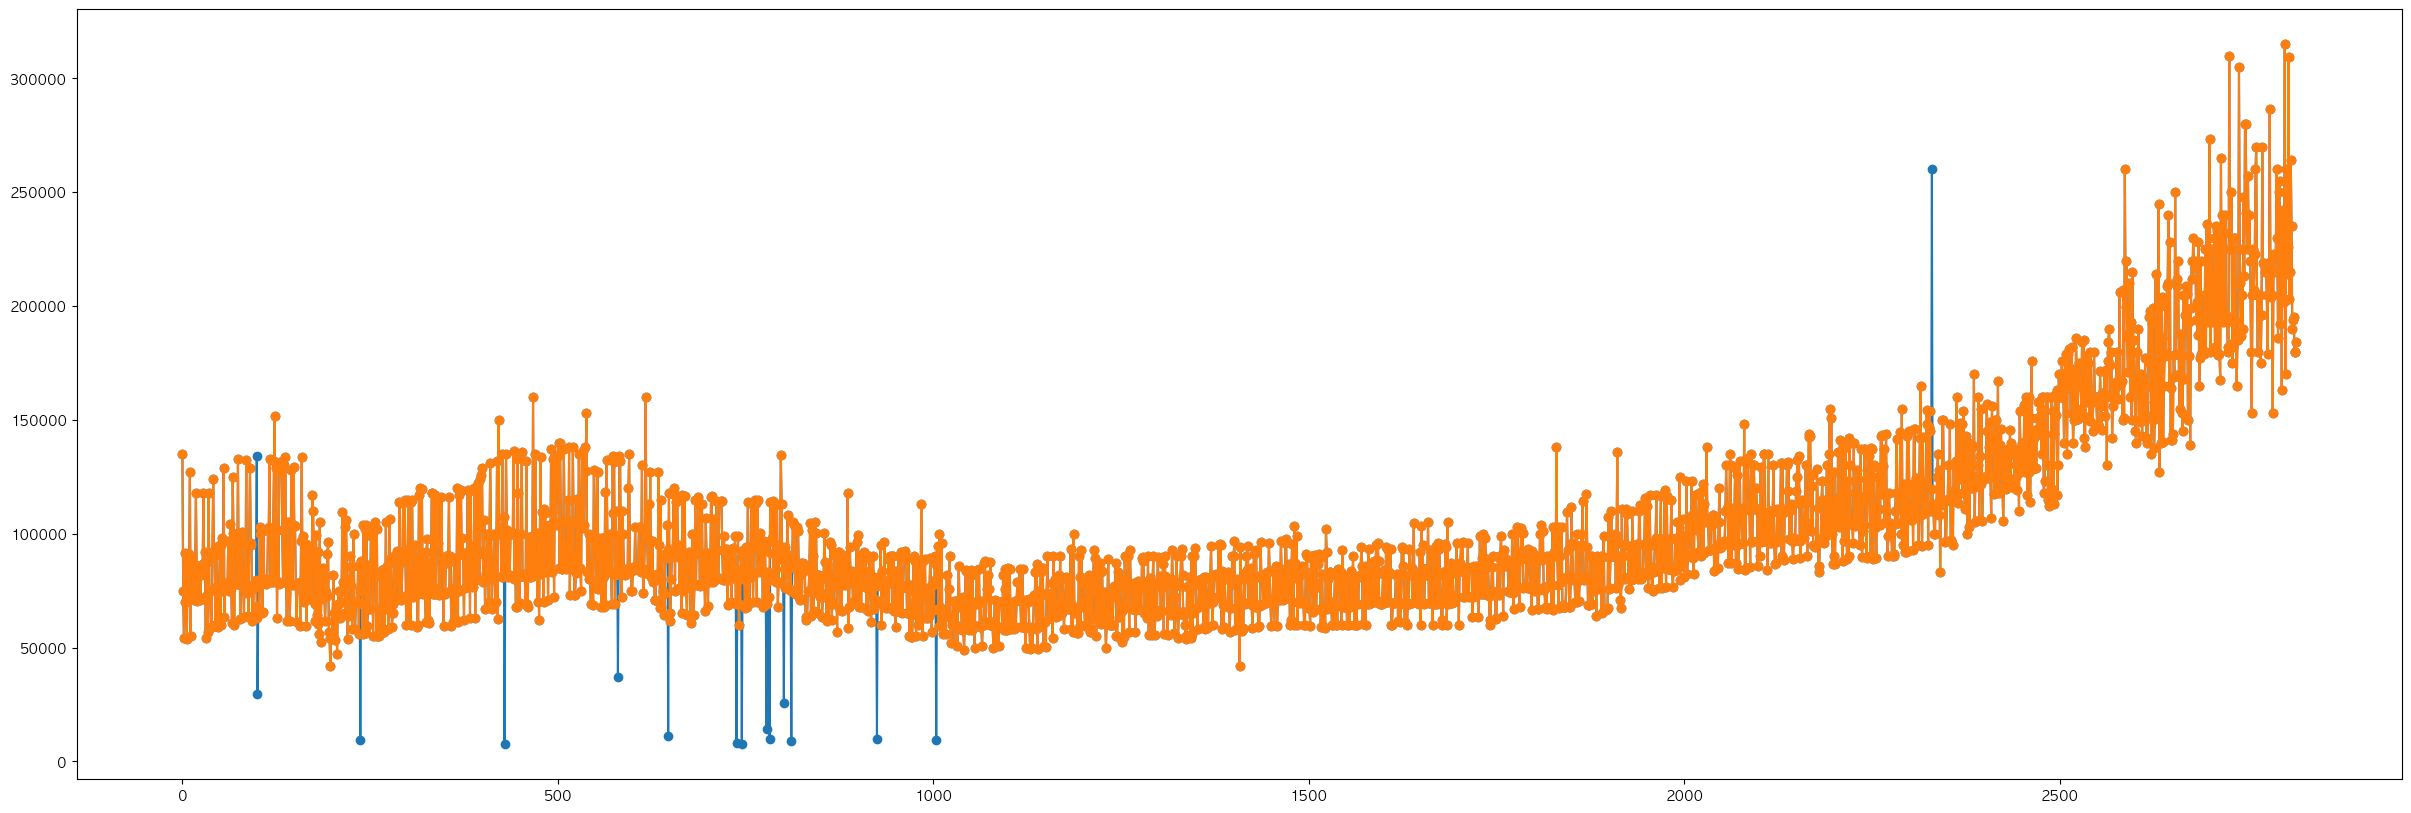

In [19]:
test = apart_df_list[3].sort_values(['계약년월', '계약일'])
test.reset_index(inplace=True)
test2 = result[3].sort_values(['계약년월', '계약일'])

plt.figure(figsize=(30, 10))
test['target'].plot(marker='o')
test2['target'].plot(marker='o')
plt.show()

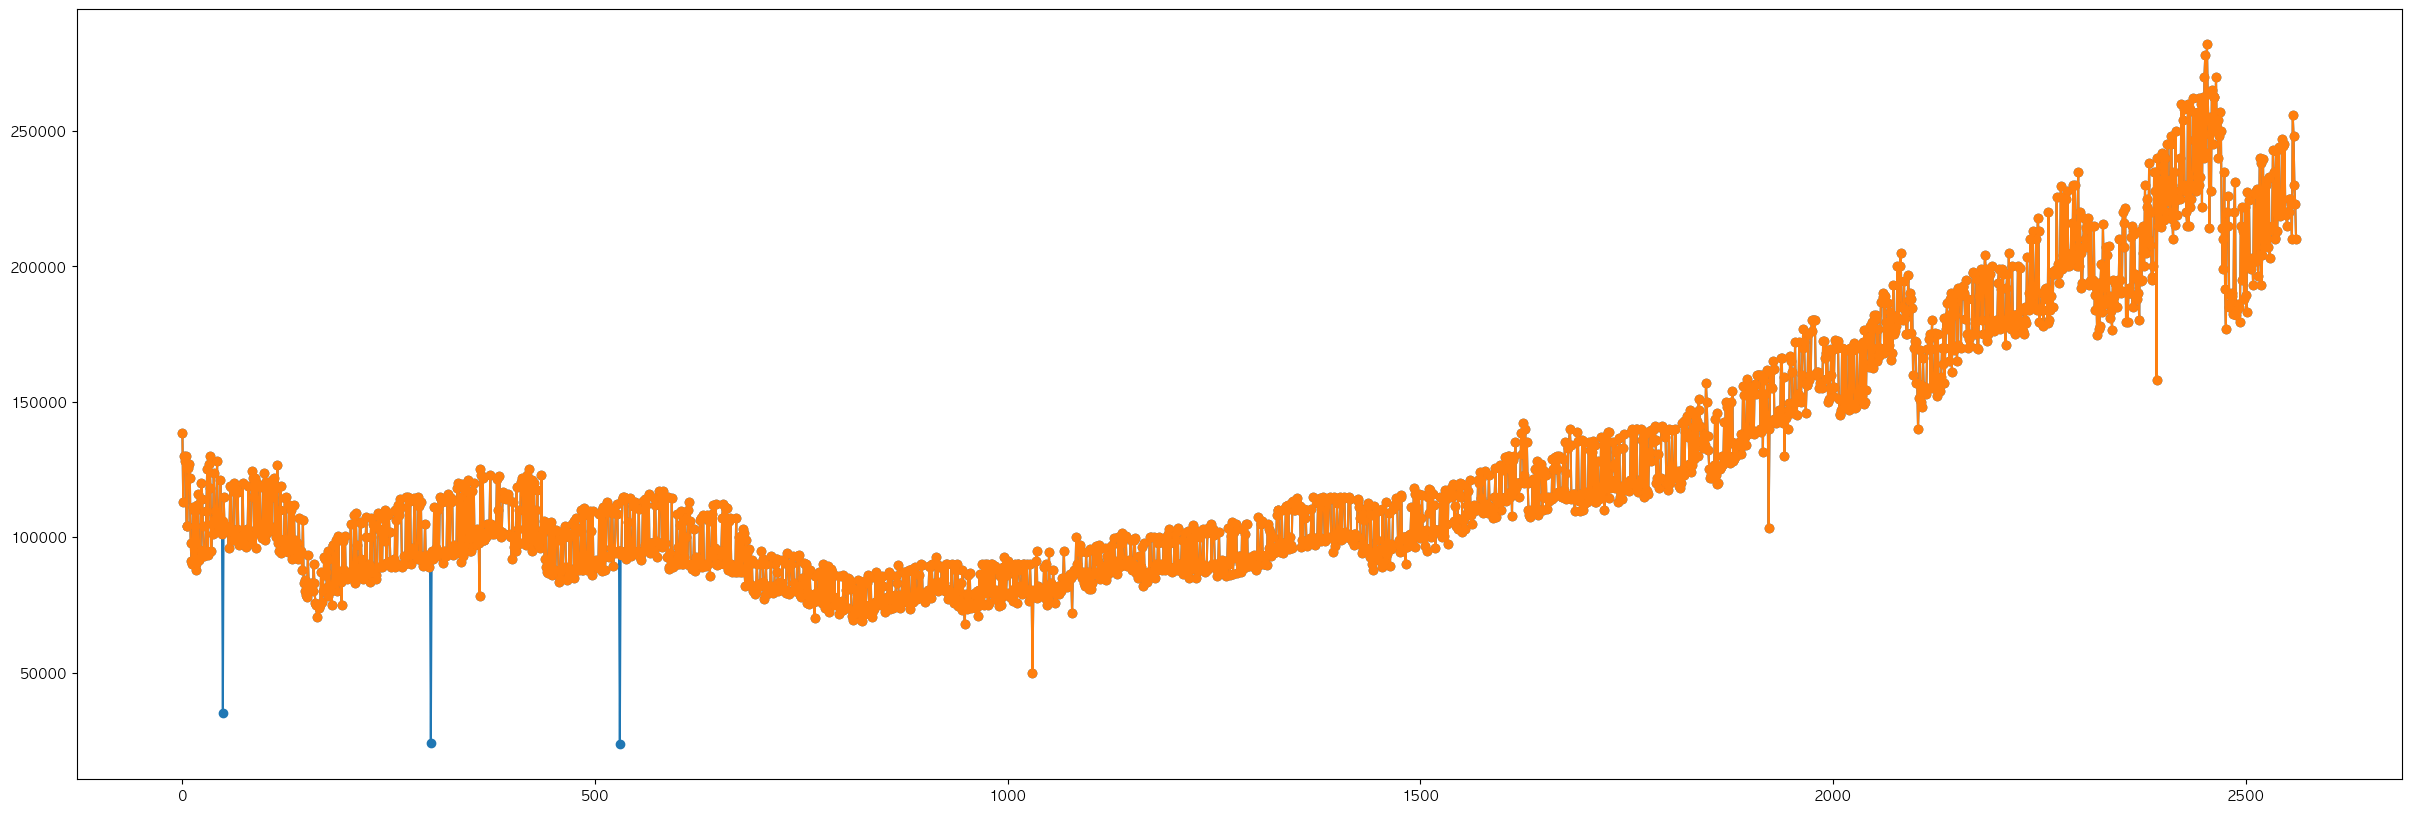

In [20]:
test = apart_df_list[20].sort_values(['계약년월', '계약일'])
test.reset_index(inplace=True)
test2 = result[20].sort_values(['계약년월', '계약일'])

plt.figure(figsize=(30, 10))
test['target'].plot(marker='o')
test2['target'].plot(marker='o')
plt.show()

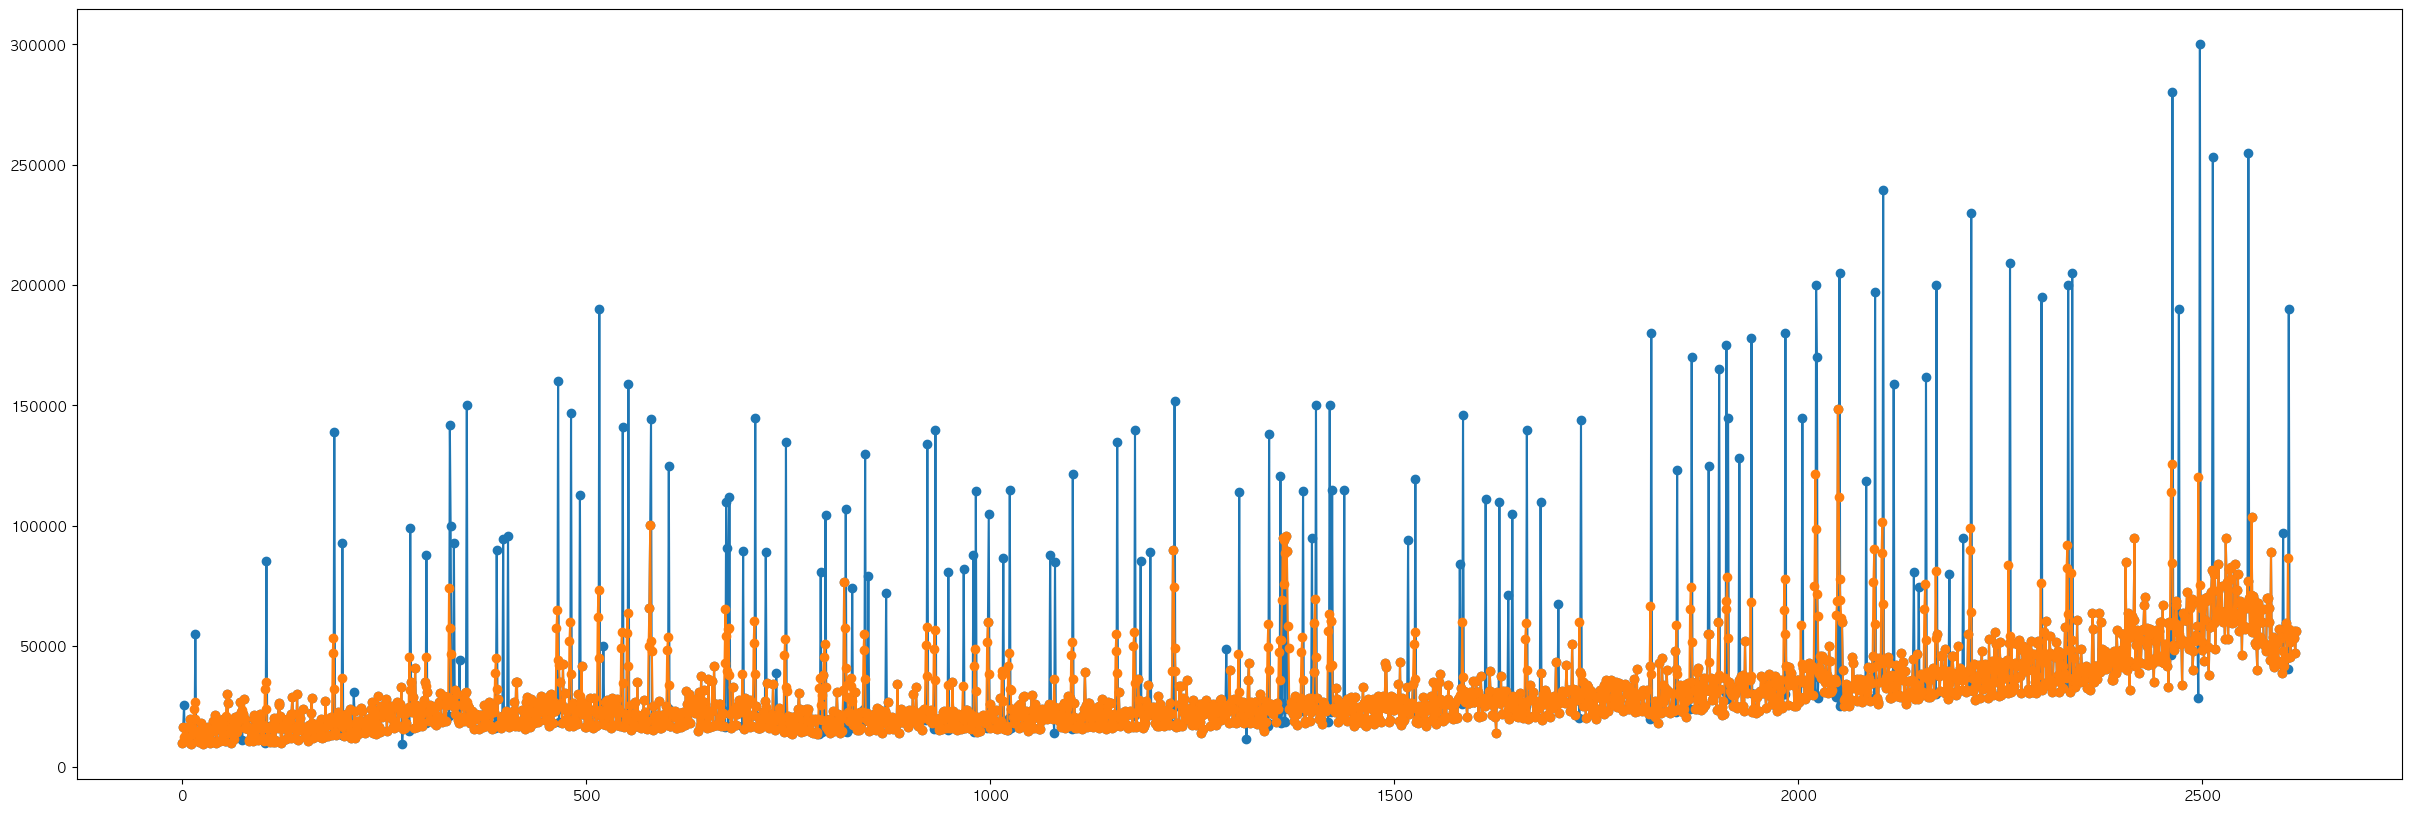

In [21]:
i = 1040
test = apart_df_list[i].sort_values(['계약년월', '계약일'])
test.reset_index(inplace=True)
test2 = result[i].sort_values(['계약년월', '계약일'])

plt.figure(figsize=(30, 10))
test['target'].plot(marker='o')
test2['target'].plot(marker='o')
plt.show()

In [24]:
result[1040][['아파트명', '좌표Y', '좌표X', '계약년월', 'target']].head(30)

,아파트명,좌표Y,좌표X,계약년월,target
0,장미,37.633702,127.067865,200701,9900.0000
1,장미,37.633702,127.067865,200701,16400.0000
2,장미,37.546199,126.918900,200701,12312.5000
3,장미,37.633702,127.067865,200701,12000.0000
4,장미,37.633702,127.067865,200701,10950.0000
5,장미,37.574300,126.817494,200701,12900.0000
6,장미,37.633702,127.067865,200701,16500.0000
7,장미,37.633702,127.067865,200701,10500.0000
8,장미,37.633702,127.067865,200701,10800.0000
9,장미,37.633702,127.067865,200701,9900.0000


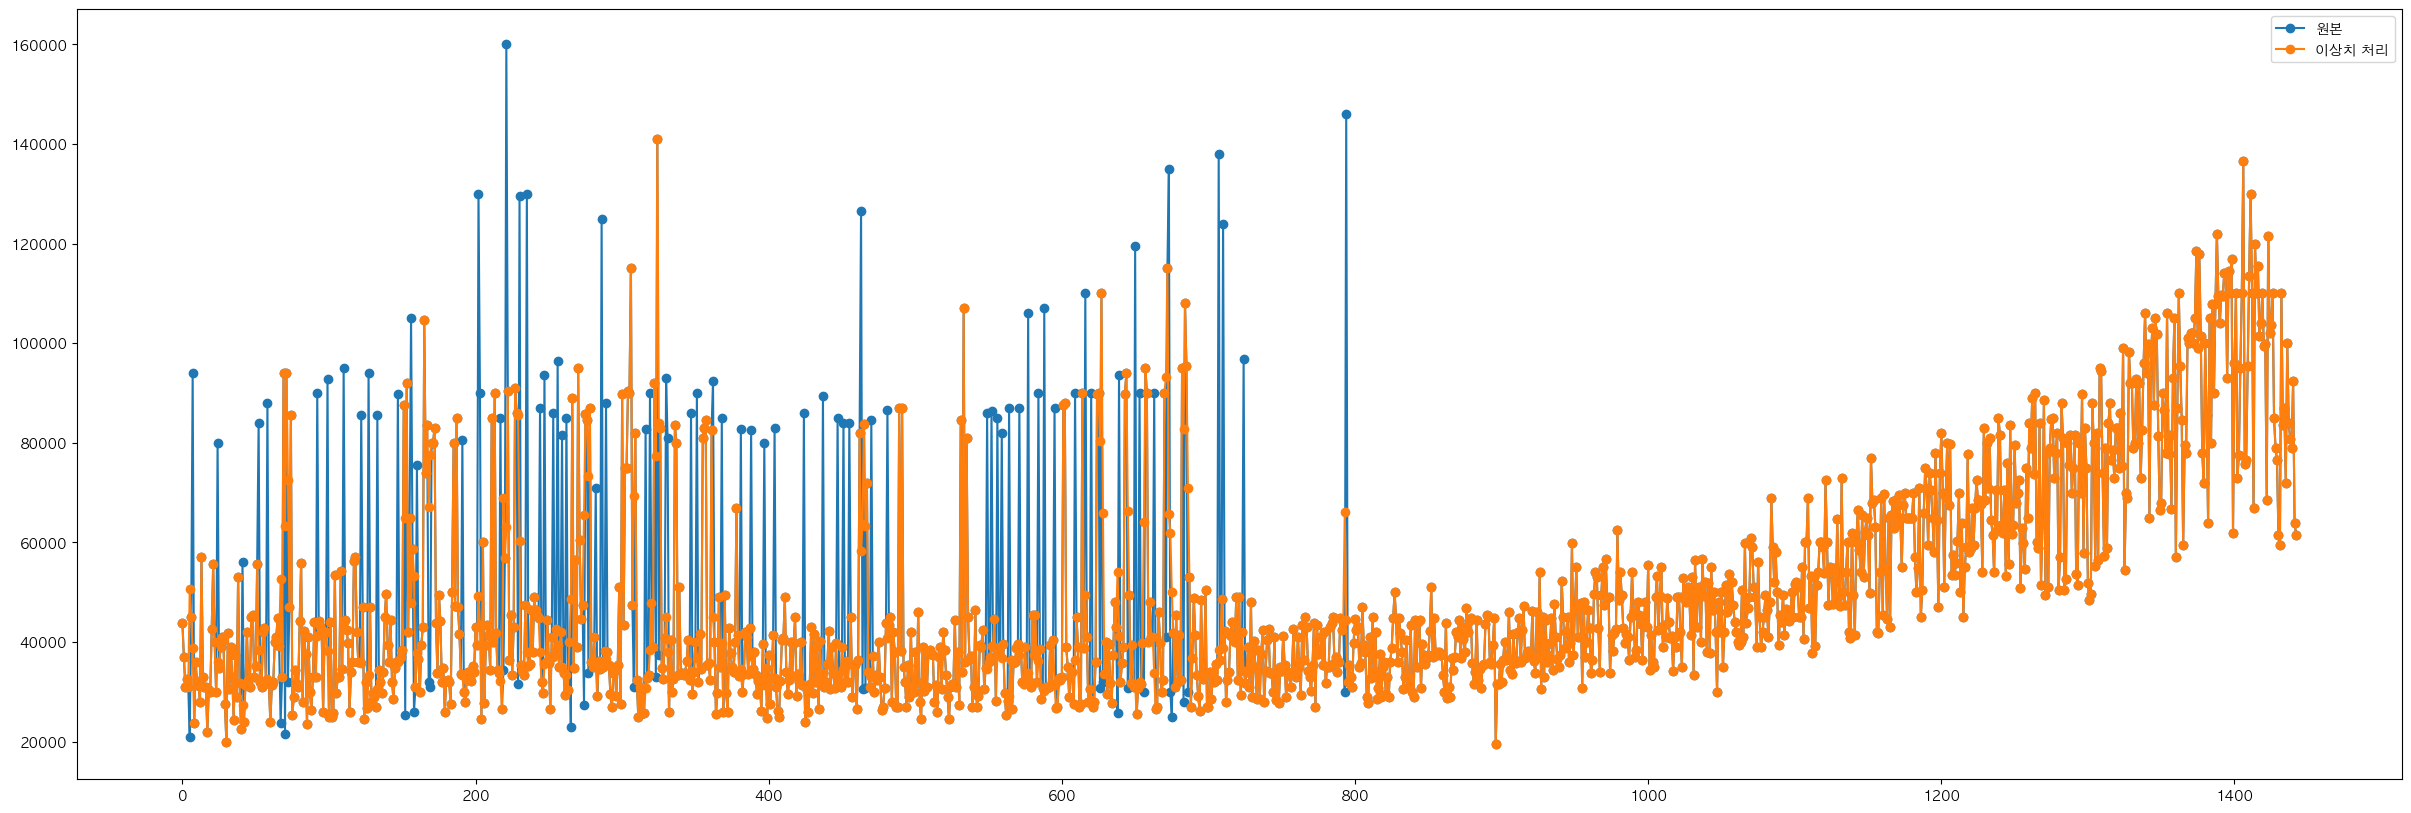

In [23]:
i = 1093
test = apart_df_list[i].sort_values(['계약년월', '계약일'])
test.reset_index(inplace=True)
test2 = result[i].sort_values(['계약년월', '계약일'])

plt.figure(figsize=(30, 10))
test['target'].plot(marker='o', label='원본')
test2['target'].plot(marker='o', label='이상치 처리')
plt.legend()
plt.show()

In [25]:
concat_df = pd.concat([apart_df for apart_df in result], axis=0)

In [26]:
concat_df

,level_0,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,...,아파트 카테고리,지하철 카테고리,구 카테고리,건설사 카테고리,가장 가까운 다리와의 거리,가장 가까운 다리 index,가장 가까운 다리,인근 한강다리 개수,인근 다리 개수 1개이상 3개 이하,학군
0,1075994,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,200703,9,2,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
1,1075995,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,200703,9,4,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
2,1004784,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,200804,17,4,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
3,1004785,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,200805,10,5,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
4,133981,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,200810,4,1,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1078700,서울특별시 강남구 역삼동,763,763.0,0.0,진달래3차,62.31,200703,8,7,...,기타,분당선,강남구,기타,3730.528347,17.0,청담대교,0.0,0,8.0
1,1078701,서울특별시 강남구 역삼동,763,763.0,0.0,진달래3차,62.31,200706,14,12,...,기타,분당선,강남구,기타,3730.528347,17.0,청담대교,0.0,0,8.0
0,1087036,서울특별시 구로구 구로동,807-39,807.0,39.0,807-39,59.84,200708,30,2,...,기타,7호선,기타,기타,6603.224673,6.0,서강대교,0.0,0,3.0
0,1109620,서울특별시 송파구 석촌동,227-12,227.0,12.0,밀란체,68.36,200705,25,6,...,기타,9호선,송파구,기타,2915.766140,18.0,잠실대교,0.0,0,6.0


In [27]:
concat_df.sort_values(['level_0'], inplace=True)
concat_df

,level_0,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,...,아파트 카테고리,지하철 카테고리,구 카테고리,건설사 카테고리,가장 가까운 다리와의 거리,가장 가까운 다리 index,가장 가까운 다리,인근 한강다리 개수,인근 다리 개수 1개이상 3개 이하,학군
65,0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
66,1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
67,2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
68,3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
69,4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,1118817,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200707,12,11,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0
23,1118818,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200708,25,10,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0
24,1118819,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200708,31,20,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0
25,1118820,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200709,15,8,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0


In [28]:
concat_df.drop(['level_0'], axis=1, inplace=True)
concat_df

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,아파트 카테고리,지하철 카테고리,구 카테고리,건설사 카테고리,가장 가까운 다리와의 거리,가장 가까운 다리 index,가장 가까운 다리,인근 한강다리 개수,인근 다리 개수 1개이상 3개 이하,학군
65,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
66,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
67,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
68,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
69,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200707,12,11,1998,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0
23,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200708,25,10,1998,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0
24,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200708,31,20,1998,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0
25,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200709,15,8,1998,...,기타,6호선,기타,현대,6109.517072,2.0,가양대교,0.0,0,2.0


In [29]:
test_df = df[df['is_test']==1]
test_df

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,아파트 카테고리,지하철 카테고리,구 카테고리,건설사 카테고리,가장 가까운 다리와의 거리,가장 가까운 다리 index,가장 가까운 다리,인근 한강다리 개수,인근 다리 개수 1개이상 3개 이하,학군
1118822,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.9700,202307,26,5,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
1118823,서울특별시 강남구 개포동,651-1,651.0,1.0,개포더샵트리에,108.2017,202308,15,10,2021,...,기타,분당선,강남구,포스코,4696.525473,17.0,청담대교,0.0,0,8.0
1118824,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,161.0000,202307,28,15,1984,...,기타,분당선,강남구,기타,4811.419486,17.0,청담대교,0.0,0,8.0
1118825,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,133.4600,202308,10,14,1984,...,기타,분당선,강남구,기타,4811.419486,17.0,청담대교,0.0,0,8.0
1118826,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,104.4300,202308,18,6,1984,...,기타,분당선,강남구,기타,4811.419486,17.0,청담대교,0.0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.6500,202307,19,13,2014,...,기타,기타,기타,기타,5918.624352,23.0,구리암사대교,0.0,0,1.0
1128090,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.6200,202307,25,12,2014,...,기타,기타,기타,기타,5918.624352,23.0,구리암사대교,0.0,0,1.0
1128091,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,101.6500,202308,27,12,2014,...,기타,기타,기타,기타,5918.624352,23.0,구리암사대교,0.0,0,1.0
1128092,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.9400,202309,2,18,2014,...,기타,기타,기타,기타,5918.624352,23.0,구리암사대교,0.0,0,1.0


In [30]:
re_df = pd.concat([concat_df, test_df], axis=0)

In [31]:
re_df[['is_test']]

,is_test
65,0
66,0
67,0
68,0
69,0
...,...
1128089,1
1128090,1
1128091,1
1128092,1


In [31]:
re_df.to_csv('../data/preprocessed/28_target_outlier.csv', index=False)

# 이상치가 어느정도 변했는지 확인

In [2]:
df1 = pd.read_csv('../data/preprocessed/27_school_district.csv')
df2 = pd.read_csv('../data/preprocessed/28_target_outlier.csv')

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_82728/3036142117.py:1: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('../data/preprocessed/27_school_district.csv')
/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_82728/3036142117.py:2: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('../data/preprocessed/28_target_outlier.csv')


In [3]:
apt_name_list = df1['아파트명'].unique().tolist()
apt_name_list

['개포6차우성',
 '개포우성3차',
 '개포자이',
 '개포주공1단지',
 '개포주공5단지',
 '개포주공6단지',
 '동양파라곤',
 '마일스디오빌',
 '아크로힐스논현',
 '대치삼성',
 '대치현대',
 '대치효성',
 '래미안대치하이스턴',
 '롯데캐슬리베',
 '테헤란로대우아이빌',
 '도곡렉슬',
 '도곡쌍용예가',
 '도곡우성',
 '래미안도곡카운티',
 '대치아이파크',
 '은마',
 '개포주공4단지',
 '개포주공7단지',
 '개포현대200동',
 '경남1',
 '경남2차',
 '뉴현대파크빌',
 '리치타운',
 '삼익대청',
 '새롬',
 '성원대치2단지',
 '시영',
 '아람손프라자/비바빌',
 '에버그린',
 '우성8',
 '우성9차',
 '우찬현대',
 '현대',
 '현대1차101동~106동',
 '현대2',
 'e-편한세상',
 '거평프리젠',
 '경남논현',
 '골든캐슬',
 '논현동월드메르디앙',
 '논현동프라임',
 '논현동한화꿈에그린',
 '논현라폴리움',
 '논현베르빌',
 '논현빌라트',
 '논현아트빌',
 '논현웰스톤',
 '논현파라곤',
 '논현프라임',
 '논현한가람빌라트',
 '동부센트레빌',
 '동현',
 '두산위브1단지',
 '두산위브2단지',
 '두영',
 '벨러스빌',
 '브라운스톤',
 '스위트캐슬레지던스',
 '신동아',
 '쌍용',
 '우민',
 '우성',
 '월드쉐르빌',
 '이산',
 '이움빌라',
 '지고하임',
 '청학',
 '케럿스테이트',
 '케이씨빌',
 '토미빌',
 '프라임',
 '학동',
 '한양빌라트',
 '한양수자인어반게이트',
 '한진로즈힐',
 '한화꿈에그린2차',
 '현대넥서스A동',
 '현대인텔렉스',
 '개포우성1',
 '개포우성2',
 '대우아이빌멤버스',
 '대우아이빌명문가',
 '대치SKVIEW',
 '대치동우정에쉐르1',
 '대치동우정에쉐르2',
 '대치우성',
 '대치하나빌',
 '대치한신휴플러스',
 '동민맥스빌A동',
 '동민맥스빌B동',
 '동양',
 '래

In [6]:
df1 = df1[df1['is_test']==0]
df3 = df2[df2['is_test']==0]

<Axes: xlabel='계약년월'>

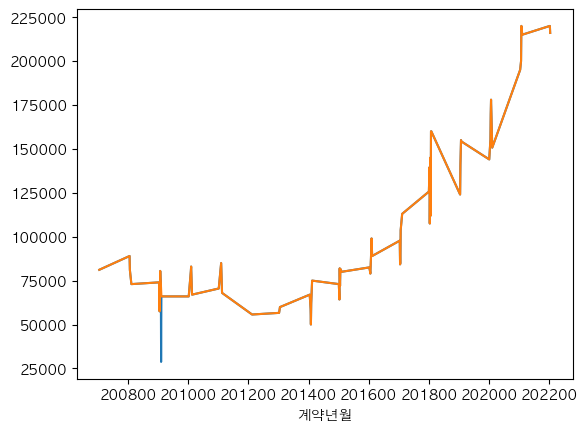

In [14]:
i = 0

tmp1 = df1[df1['아파트명']==apt_name_list[i]]
tmp2 = df2[df2['아파트명']==apt_name_list[i]]

tmp1.groupby('계약년월')['target'].mean().plot()
tmp2.groupby('계약년월')['target'].mean().plot()

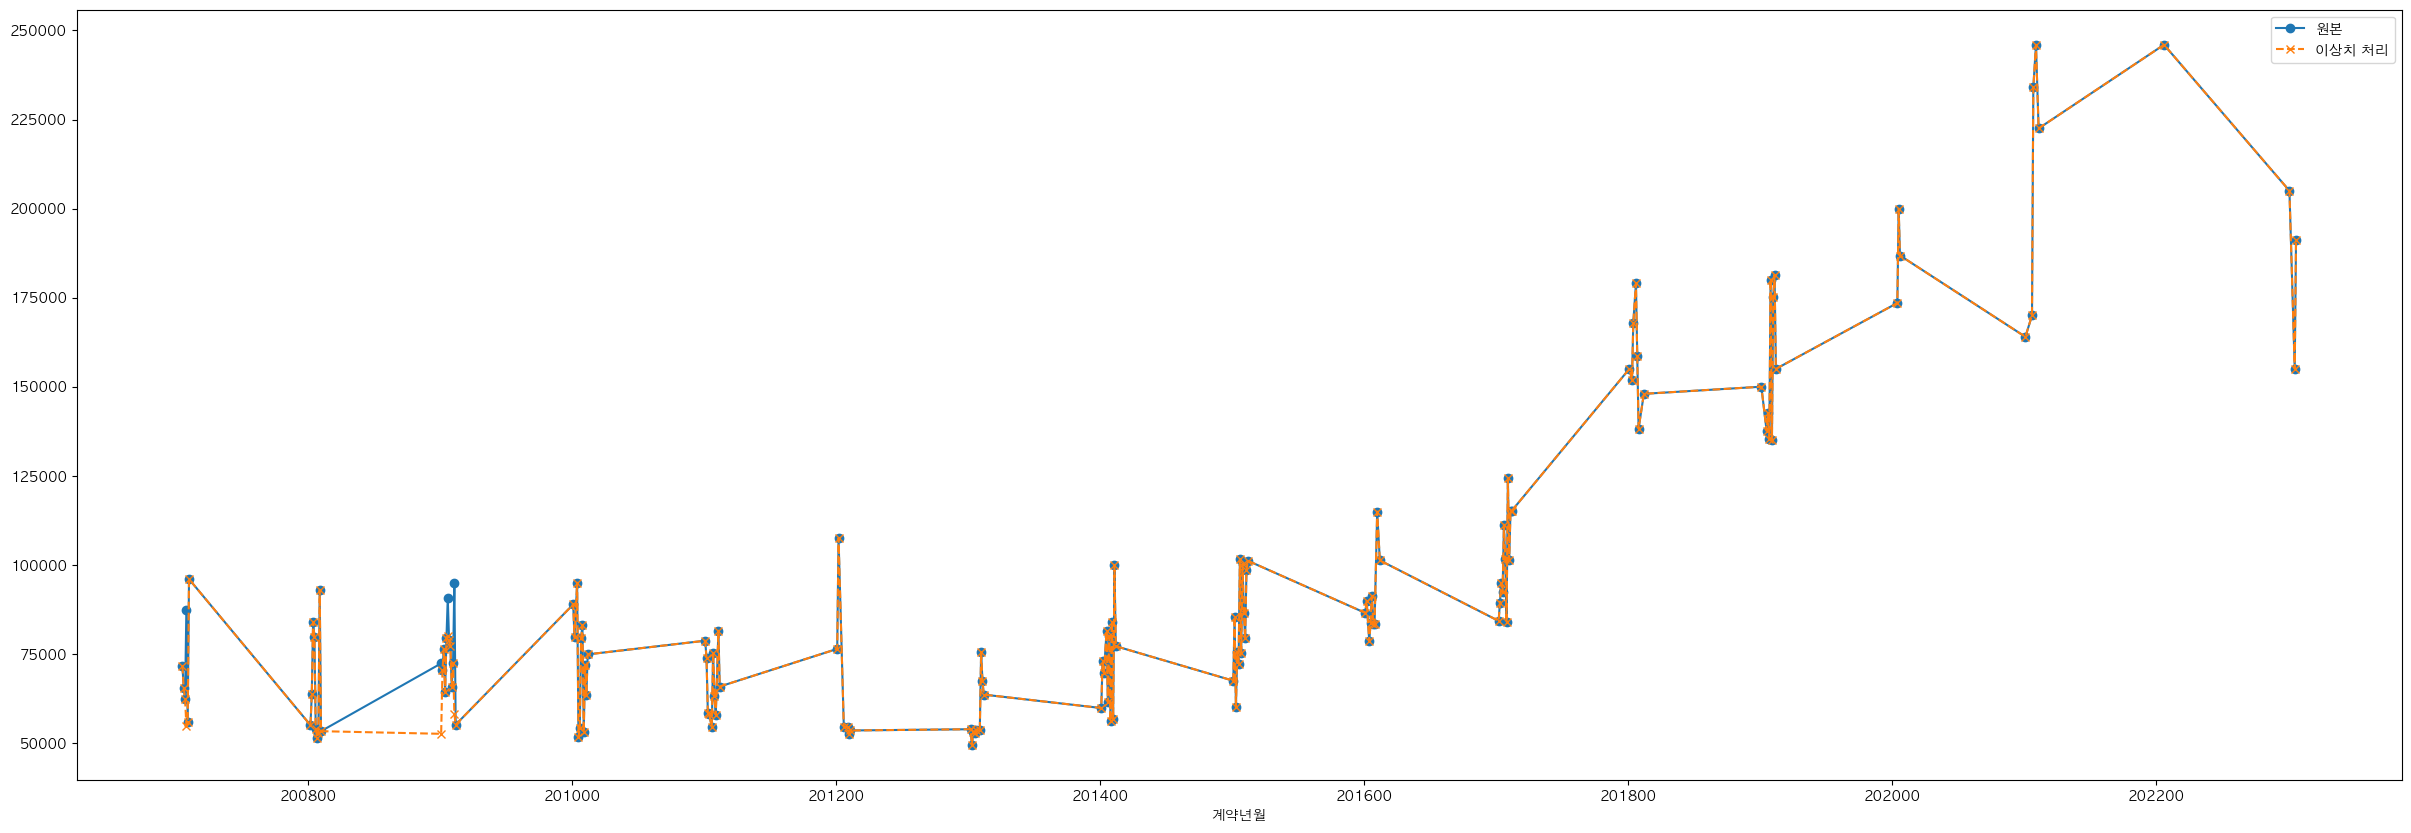

In [20]:
i = 10

tmp1 = df1[df1['아파트명']==apt_name_list[i]]
tmp2 = df2[df2['아파트명']==apt_name_list[i]]

plt.figure(figsize=(30, 10))
tmp1.groupby('계약년월')['target'].mean().plot(marker='o', label='원본')
tmp2.groupby('계약년월')['target'].mean().plot(linestyle='--', marker='x', label='이상치 처리')
plt.legend()
plt.show()

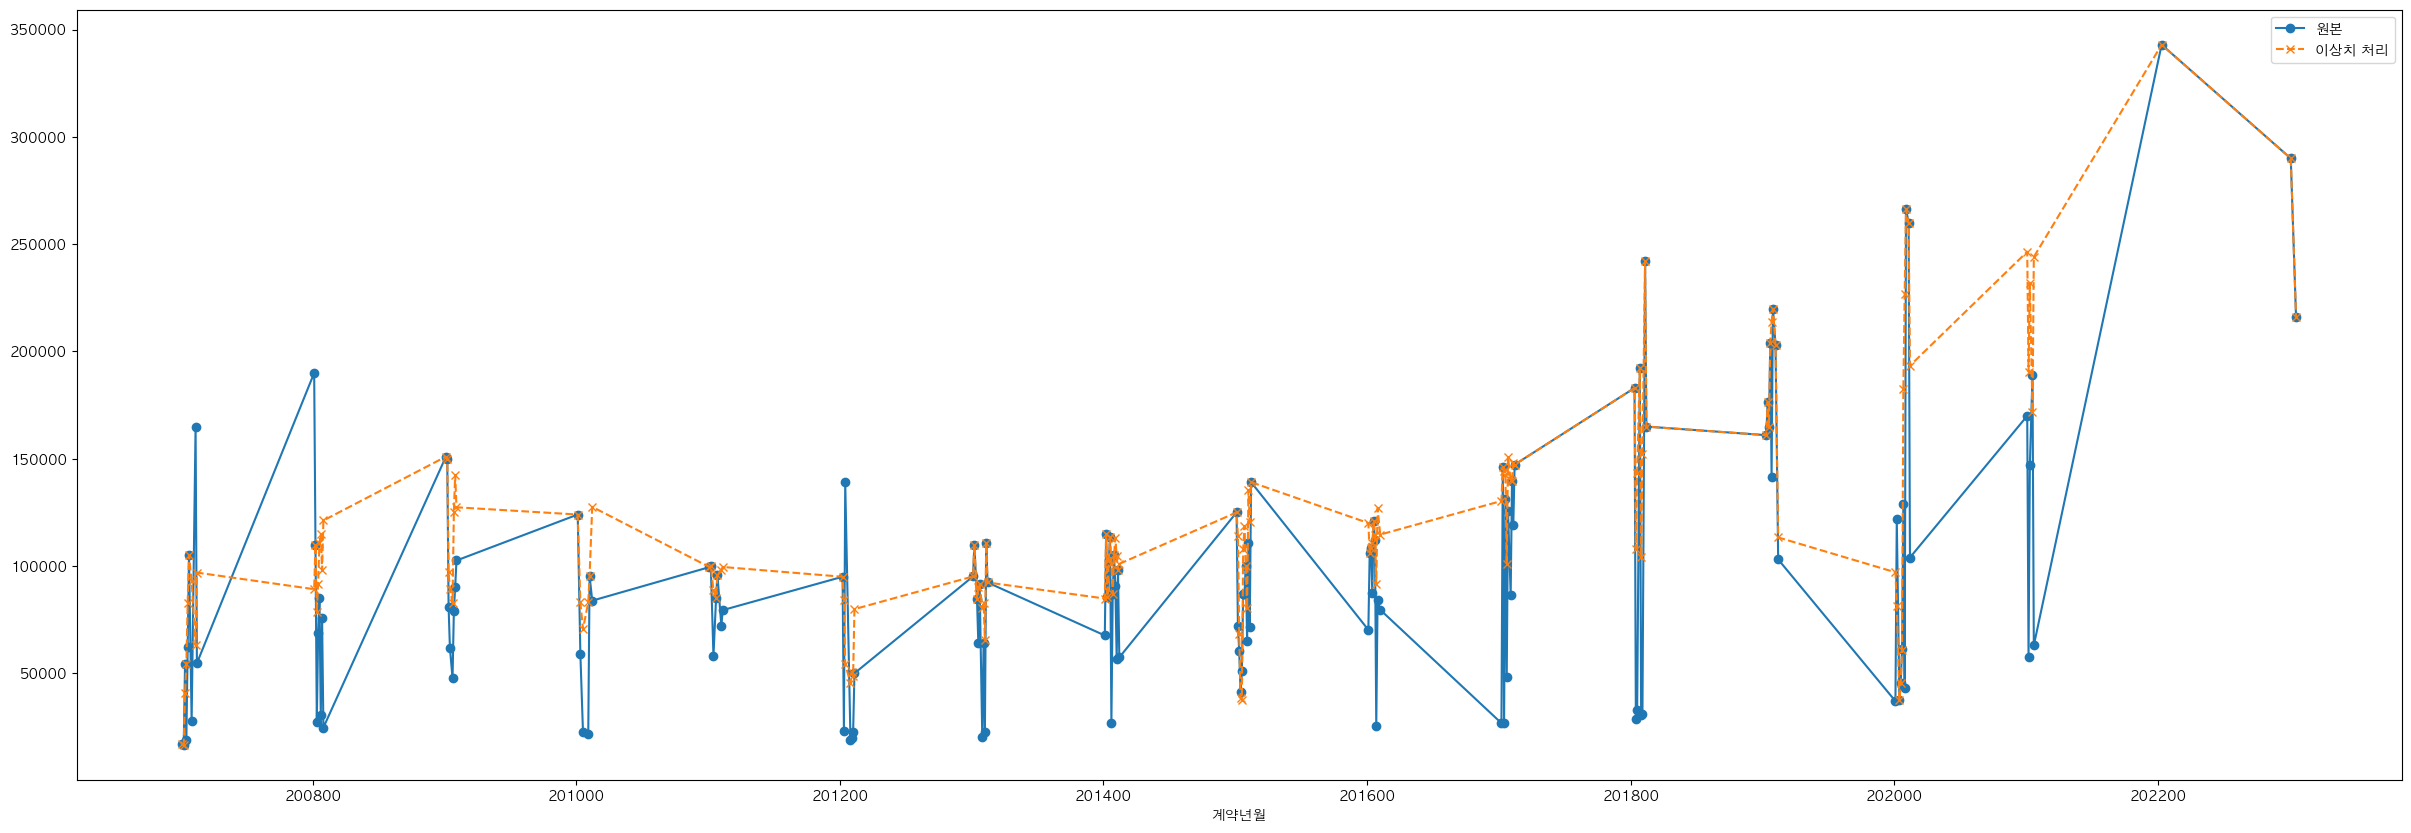

In [55]:
i = 24

tmp1 = df1[df1['아파트명']==apt_name_list[i]]
tmp2 = df2[df2['아파트명']==apt_name_list[i]]

plt.figure(figsize=(30, 10))
tmp1.groupby('계약년월')['target'].mean().plot(marker='o', label='원본')
tmp2.groupby('계약년월')['target'].mean().plot(linestyle='--', marker='x', label='이상치 처리')
plt.legend()
plt.show()

# 구별 target

In [41]:
tmp = df.groupby('구')['target'].mean()
tmp =pd.DataFrame(tmp).reset_index()
tmp

,구,target
0,강남구,114847.461503
1,강동구,54402.872801
2,강북구,38316.975201
3,강서구,44215.453701
4,관악구,41954.133039
5,광진구,67158.379293
6,구로구,38605.012447
7,금천구,33709.248647
8,노원구,33870.444730
9,도봉구,31924.613711


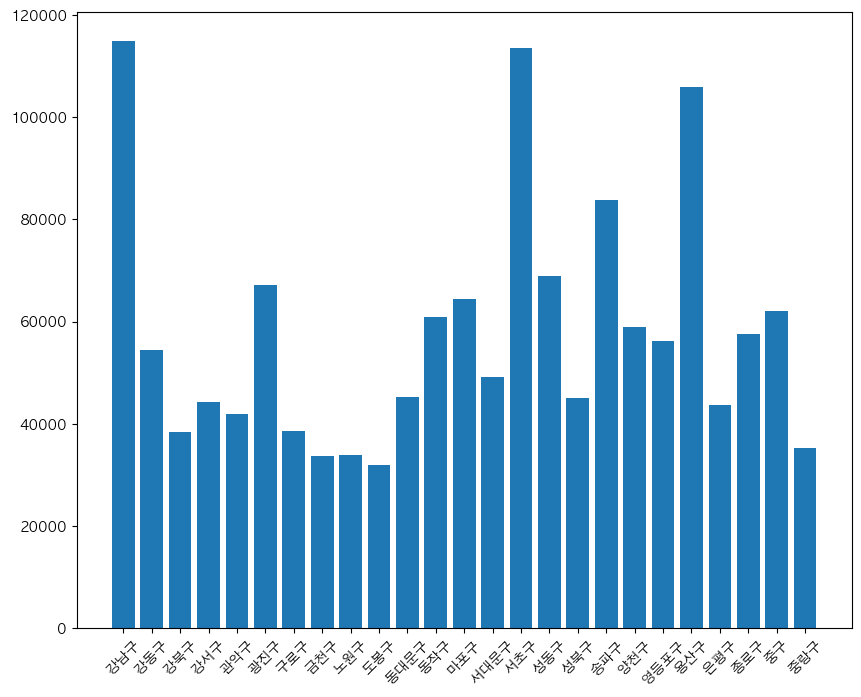

In [43]:
plt.figure(figsize=(10, 8))
plt.bar(tmp['구'], tmp['target'])
plt.xticks(rotation=45)
plt.show()

In [47]:
district_list = df['구'].unique().tolist()
district_list

['강남구',
 '강동구',
 '강북구',
 '강서구',
 '관악구',
 '광진구',
 '구로구',
 '금천구',
 '노원구',
 '도봉구',
 '동대문구',
 '동작구',
 '마포구',
 '서대문구',
 '서초구',
 '성동구',
 '성북구',
 '송파구',
 '양천구',
 '영등포구',
 '용산구',
 '은평구',
 '종로구',
 '중구',
 '중랑구']

In [49]:
district_split_list = []
for district in district_list:
    district_split_list.append(df[df['구'] == district])

In [52]:
district_split_list[0]

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,아파트 카테고리,지하철 카테고리,구 카테고리,건설사 카테고리,가장 가까운 다리와의 거리,가장 가까운 다리 index,가장 가까운 다리,인근 한강다리 개수,인근 다리 개수 1개이상 3개 이하,학군
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,기타,분당선,강남구,기타,5581.622466,17.0,청담대교,0.0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123928,서울특별시 강남구 일원동,742,742.0,0.0,디에이치포레센트,84.94,202308,12,7,2021,...,포레,3호선,강남구,현대,3984.052508,18.0,잠실대교,0.0,0,8.0
1123929,서울특별시 강남구 일원동,742,742.0,0.0,디에이치포레센트,84.94,202308,19,6,2021,...,포레,3호선,강남구,현대,3984.052508,18.0,잠실대교,0.0,0,8.0
1123930,서울특별시 강남구 일원동,742,742.0,0.0,디에이치포레센트,84.94,202308,31,9,2021,...,포레,3호선,강남구,현대,3984.052508,18.0,잠실대교,0.0,0,8.0
1123931,서울특별시 강남구 일원동,734,734.0,0.0,상록수,74.54,202307,7,3,1993,...,기타,3호선,강남구,대우,4839.238469,18.0,잠실대교,0.0,0,8.0


In [59]:
tmp = district_split_list[0].sort_values('계약년월')
tmp.reset_index(drop=True, inplace=True)
tmp

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,아파트 카테고리,지하철 카테고리,구 카테고리,건설사 카테고리,가장 가까운 다리와의 거리,가장 가까운 다리 index,가장 가까운 다리,인근 한강다리 개수,인근 다리 개수 1개이상 3개 이하,학군
0,서울특별시 강남구 도곡동,162-4,162.0,4.0,울트라멤버스,120.5100,200701,30,7,2003,...,기타,3호선,강남구,기타,4600.118661,17.0,청담대교,0.0,0,8.0
1,서울특별시 강남구 수서동,708,708.0,0.0,삼익,49.2000,200701,10,10,1992,...,기타,분당선,강남구,기타,4028.552153,18.0,잠실대교,0.0,0,8.0
2,서울특별시 강남구 수서동,708,708.0,0.0,삼익,49.2000,200701,15,7,1992,...,기타,분당선,강남구,기타,4028.552153,18.0,잠실대교,0.0,0,8.0
3,서울특별시 강남구 수서동,708,708.0,0.0,삼익,84.4800,200701,20,9,1992,...,기타,분당선,강남구,기타,4028.552153,18.0,잠실대교,0.0,0,8.0
4,서울특별시 강남구 수서동,708,708.0,0.0,삼익,49.2000,200701,25,2,1992,...,기타,분당선,강남구,기타,4028.552153,18.0,잠실대교,0.0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69651,서울특별시 강남구 개포동,138,138.0,0.0,디에이치아너힐즈,59.7479,202309,9,17,2019,...,기타,분당선,강남구,기타,5156.643620,17.0,청담대교,0.0,0,8.0
69652,서울특별시 강남구 수서동,747,747.0,0.0,삼성,84.9700,202309,2,12,1997,...,기타,3호선,강남구,기타,4413.788544,18.0,잠실대교,0.0,0,8.0
69653,서울특별시 강남구 개포동,12,12.0,0.0,삼익대청,39.5300,202309,16,5,1992,...,기타,분당선,강남구,기타,3673.991294,18.0,잠실대교,0.0,0,8.0
69654,서울특별시 강남구 대치동,316,316.0,0.0,은마,76.7900,202309,11,2,1979,...,기타,3호선,강남구,기타,3218.248483,17.0,청담대교,0.0,0,8.0


In [61]:
tmp[['계약년월', 'target']]

,계약년월,target
0,200701,92000.0
1,200701,43500.0
2,200701,44800.0
3,200701,79000.0
4,200701,40700.0
...,...,...
69651,202309,NaN
69652,202309,NaN
69653,202309,NaN
69654,202309,NaN


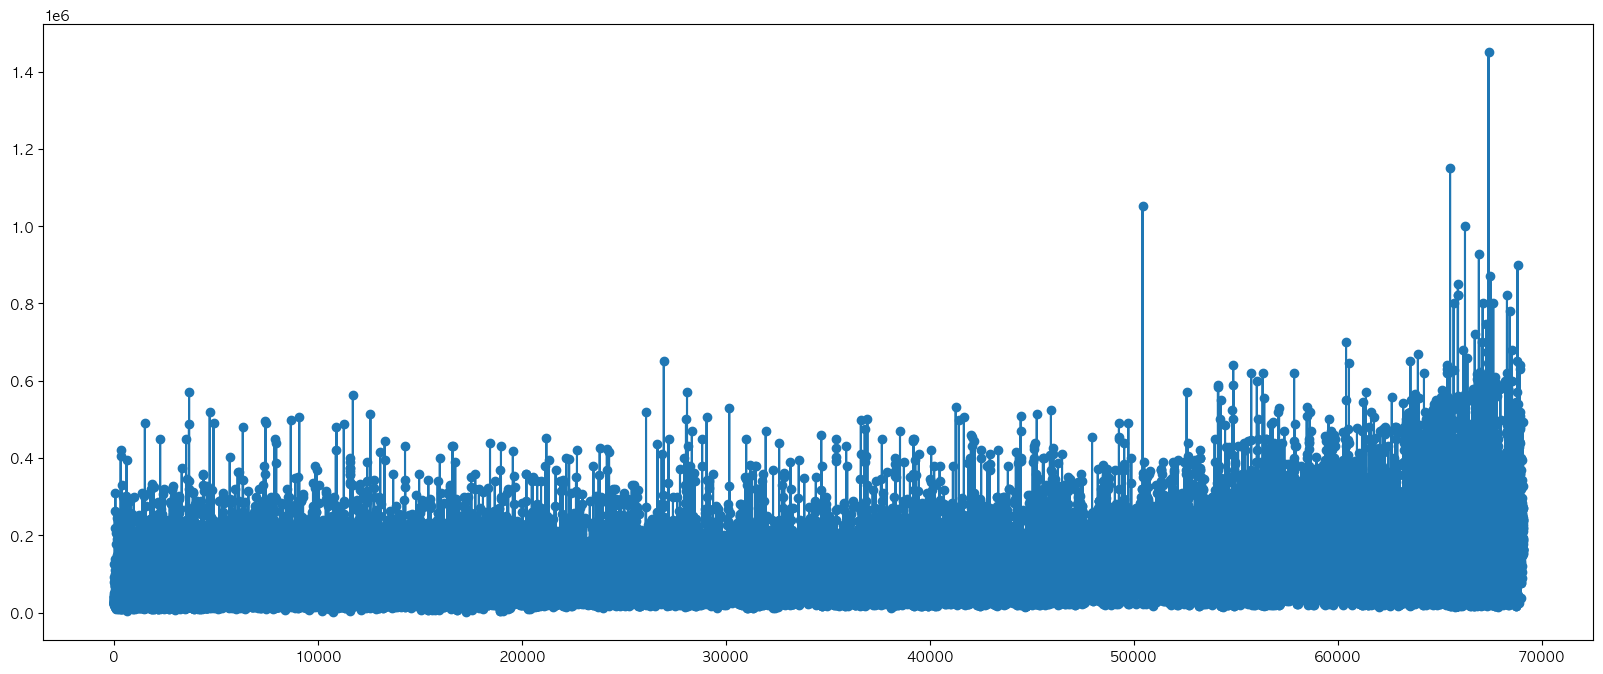

In [60]:
plt.figure(figsize=(20, 8))
tmp['target'].plot(marker='o')
plt.show()

In [63]:
df.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       ...
       '아파트 카테고리', '지하철 카테고리', '구 카테고리', '건설사 카테고리', '가장 가까운 다리와의 거리',
       '가장 가까운 다리 index', '가장 가까운 다리', '인근 한강다리 개수', '인근 다리 개수 1개이상 3개 이하',
       '학군'],
      dtype='object', length=103)